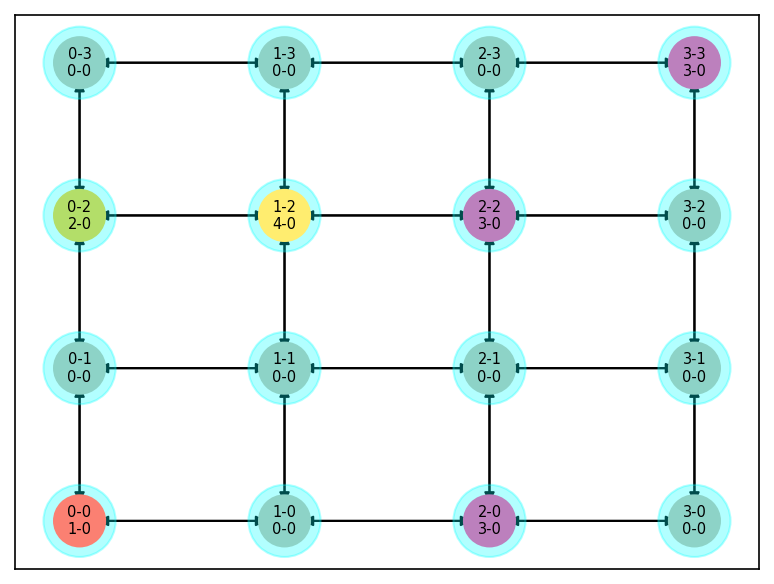

In [1]:
# logic
import random
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt

from collections import deque


class Thing:
    def __init__(self, name=''):
        self.name = name

    def __repr__(self):
        return self.name


class Problem(Thing):
    def __init__(self, name):
        super().__init__(name)


class GameProblem(Problem):
    def __init__(self, name):
        super().__init__(name)

    def check_win(self):
        pass


class Node(Thing):
    def __init__(self, name, children=None, loc=None, state=-1, order=0):
        super().__init__(name)
        self.children = children if children is not None else {}
        self.loc = loc
        self.state = state
        self.order = order
        self.stench = False
        self.breeze = False
        self.spark = False

    def add_child(self, child_name, child_weight):
        self.children[child_name] = child_weight


class Graph(Thing):
    def __init__(self, name):
        super().__init__(name)
        self.node_list = []
        self.node_map = {}

    def add_node(self, node):
        self.node_list.append(node)
        self.node_map[node.name] = node

    def draw(self, font_size=10, k_layout=0.1):
        plt.rcdefaults()
        plt.rcParams['figure.dpi'] = 150
        g = nx.DiGraph()
        edges = []
        edges_map = {}
        for node in self.node_list:
            for key, val in node.children.items():
                edges.append((node.name, key, 1 / val))
                edges_map[(node.name, key)] = val
        g.add_weighted_edges_from(edges)
        g.add_nodes_from(self.node_map)
        pos_map = {}
        nodes_label = {}
        for node in self.node_list:
            if node.loc is not None:
                pos_map[node.name] = node.loc
            nodes_label[node.name] = node.name + "\n" + str(node.state) + "-" + str(node.order)
        rand_seed = random.randint(1, 1000)
        if len(pos_map) > 0:
            locs = nx.spring_layout(g, pos=pos_map, fixed=pos_map.keys(), seed=rand_seed, k=k_layout)
        else:
            locs = nx.spring_layout(g, seed=rand_seed, k=k_layout)
        # 画一下移动的路径
        g2 = nx.Graph()
        g2.add_nodes_from(self.node_map)
        color_arr_2 = [self.node_map[node_g].order for node_g in g.nodes]
        nx.draw_networkx_nodes(g, pos=locs,
                               node_size=1200,
                               node_color=color_arr_2,
                               alpha=0.3,
                               cmap=plt.cm.cool)
        color_arr = [self.node_map[node_g].state for node_g in g.nodes]
        nx.draw_networkx_nodes(g, pos=locs,
                               node_size=600,
                               node_color=color_arr,
                               cmap=plt.cm.Set3)
        nx.draw_networkx_labels(g, pos=locs,
                                labels=nodes_label,
                                font_size=font_size,
                                font_color='black')
        nx.draw_networkx_edges(g, pos=locs, )


class Agent(Thing):
    def __init__(self, loc=None):
        super().__init__('player')
        self.loc = loc
        self.score = 0
        self.order = 1
        self.path = ""

    def move_to(self, node):
        node.order = self.order
        self.order += 1
        self.loc = node.loc
        self.path += " " + node.name
        self.score -= 1
        print("agent移动至{},分数{}".format(self.loc, self.score))

    def __repr__(self):
        return "agent当前在{},分数{},路线{}".format(self.loc, self.score, self.path)


class WumpusWorld(Graph, GameProblem):
    def __init__(self, name):
        super().__init__(name)
        # 1是player，2是wumpus，3是hole，4是gold
        map_src = pd.read_csv("../data/wumpus_world.csv", header=None)
        self.map2 = map_src.values.tolist()
        # map_src.columns=['a','a','a','a']
        for row_id, col in map_src.iterrows():
            for col_id, val in col.items():
                # print(row_id, col_id, val)
                node = Node("{}-{}".format(row_id, col_id), state=val)
                node.loc = (row_id, col_id)
                self.add_node(node)
                self.map2[row_id][col_id] = node
                # print(node)
        for x in range(map_src.shape[0]):
            for y in range(map_src.shape[1]):
                node = self.node_at(x, y)
                if self.node_at(x - 1, y) is not None:
                    node.add_child(self.node_at(x - 1, y).name, 1)
                if self.node_at(x + 1, y) is not None:
                    node.add_child(self.node_at(x + 1, y).name, 1)
                if self.node_at(x, y - 1) is not None:
                    node.add_child(self.node_at(x, y - 1).name, 1)
                if self.node_at(x, y + 1) is not None:
                    node.add_child(self.node_at(x, y + 1).name, 1)
                for child_name in node.children:
                    child = self.node_map[child_name]
                    child.stench = child.stench if child.stench else node.state == 2
                    child.breeze = child.breeze if child.breeze else node.state == 3
                    child.spark = child.spark if child.spark else node.state == 4
        self.start_node = [node for node in self.node_list if node.state == 1][0]
        self.agent = Agent(loc=self.start_node.loc)
        self.gold_loc = [node for node in self.node_list if node.state == 4][0].loc

    def node_xy(self, xy):
        return self.node_at(xy[0], xy[1])

    def node_at(self, x, y):
        node_name = "{}-{}".format(x, y)
        return self.node_map[node_name] if node_name in self.node_map else None

    def check_win(self):
        node = self.node_xy(self.agent.loc)
        if node.state == 4:
            self.agent.score += 1000
            print("恭喜！找到黄金！", self.agent)
            return True
        else:
            if node.state == 2:
                self.agent.score -= 1000
                print("Agent被Wumpus吃掉！", self.agent)
            if node.state == 3:
                self.agent.score -= 100
                print("Agent掉进了井里！", self.agent)
            return False

    def pick(self, x, y):
        node = self.node_at(x, y)
        if node is not None and node.order == 0:
            self.agent.move_to(node)
            self.draw()
            self.check_win()
        else:
            print("移动失败")


problem = WumpusWorld('game')
problem.draw(font_size=7, k_layout=0.3)

agent移动至(2, 1),分数-2


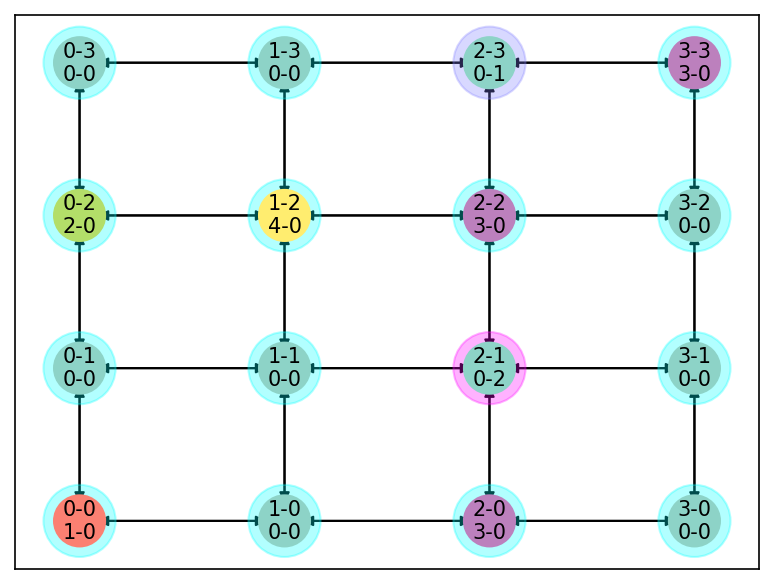

In [6]:
problem.pick(2, 1)

In [55]:
problem.map2

[[0-0, 0-1, 0-2, 0-3],
 [1-0, 1-1, 1-2, 1-3],
 [2-0, 2-1, 2-2, 2-3],
 [3-0, 3-1, 3-2, 3-3]]

agent移动至(0, 0),分数-1
agent移动至(0, 1),分数-2
agent移动至(1, 0),分数-3
agent移动至(2, 0),分数-4
Agent掉进了井里！ agent当前在(2, 0),分数-104,路线 0-0 0-1 1-0 2-0
agent移动至(2, 1),分数-105
agent移动至(3, 0),分数-106
agent移动至(3, 1),分数-107
agent移动至(3, 2),分数-108
agent移动至(3, 3),分数-109
Agent掉进了井里！ agent当前在(3, 3),分数-209,路线 0-0 0-1 1-0 2-0 2-1 3-0 3-1 3-2 3-3
agent移动至(2, 3),分数-210
agent移动至(3, 1),分数-211
agent移动至(2, 2),分数-212
Agent掉进了井里！ agent当前在(2, 2),分数-312,路线 0-0 0-1 1-0 2-0 2-1 3-0 3-1 3-2 3-3 2-3 3-1 2-2
agent移动至(1, 2),分数-313
恭喜！找到黄金！ agent当前在(1, 2),分数687,路线 0-0 0-1 1-0 2-0 2-1 3-0 3-1 3-2 3-3 2-3 3-1 2-2 1-2


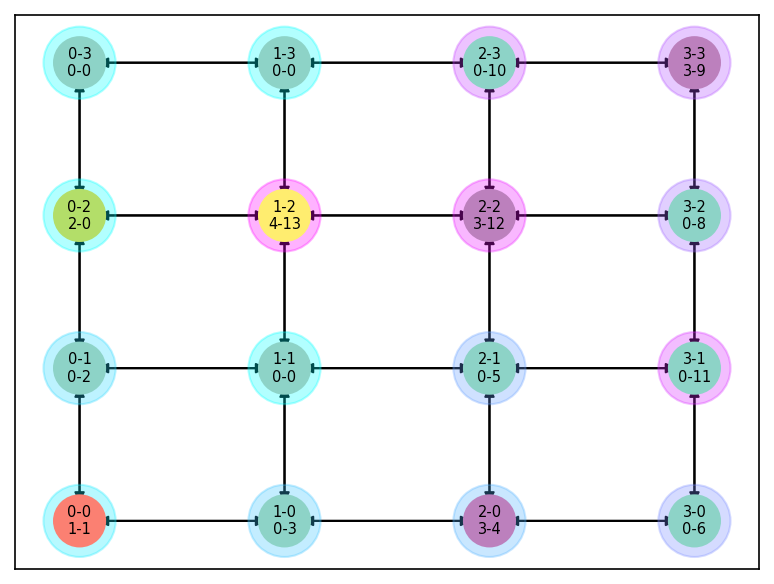

In [7]:
# 启发式Agent
class SearchWumpusWorld(WumpusWorld):
    def __init__(self, name):
        super().__init__(name)

    def do_search(self):
        queue = [(self.start_node, 0)]
        while len(queue) > 0:
            self.choose_action(queue)
            if self.check_win():
                break
        problem.draw(font_size=7, k_layout=0.3)

    def choose_action(self, queue):
        # 对可选的行为排序
        queue.sort(key=lambda x: x[1], reverse=True)
        # 选择代价最小的
        node, sort_score = queue.pop()
        self.agent.move_to(node)
        # 把新的可选的节点加进来
        for child_name in node.children:
            child = self.node_map[child_name]
            if child.order == 0:
                child_score = 0
                if child.stench:
                    child_score -= 10
                if child.breeze:
                    child_score -= 5
                if child.spark:
                    child_score += 10
                queue.append((child, child_score))


problem = SearchWumpusWorld('search')
problem.do_search()

['0-0']
[0]
0-0
agent移动至(0, 0),分数-1
['1-0', '0-1']
[0, 0]
0-1
agent移动至(0, 1),分数-2
['1-1', '0-2', '1-0']
[-50, -50, 0]
1-0
agent移动至(1, 0),分数-3
['0-2', '1-1', '2-0']
[-100, 0, 0]
2-0
agent移动至(2, 0),分数-4
Agent掉进了井里！ agent当前在(2, 0),分数-104,路线 0-0 0-1 1-0 2-0
['0-2', '1-1', '3-0', '2-1']
[-100, 0, 0, 0]
2-1
agent移动至(2, 1),分数-105
['0-2', '1-1', '3-0', '3-1', '2-2']
[-100, 0, 0, 0, 0]
2-2
agent移动至(2, 2),分数-106
Agent掉进了井里！ agent当前在(2, 2),分数-206,路线 0-0 0-1 1-0 2-0 2-1 2-2
['0-2', '1-1', '3-0', '3-1', '1-2', '3-2', '2-3']
[-100, 0, 0, 0, 30, 30, 30]
2-3
agent移动至(2, 3),分数-207
['0-2', '1-1', '3-0', '3-1', '1-3', '3-3', '1-2', '3-2']
[-100, 0, 0, 0, 0, 0, 30, 30]
3-2
agent移动至(3, 2),分数-208
['0-2', '1-1', '3-0', '3-1', '1-3', '3-3', '1-2']
[-100, 0, 0, 0, 0, 0, 30]
1-2
agent移动至(1, 2),分数-209
恭喜！找到黄金！ agent当前在(1, 2),分数791,路线 0-0 0-1 1-0 2-0 2-1 2-2 2-3 3-2 1-2


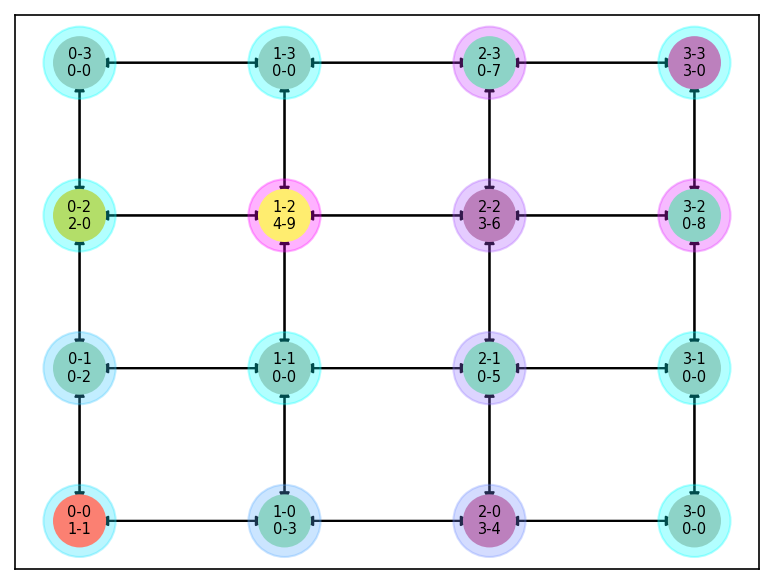

In [12]:
# 逻辑Agent
# 这个逻辑判断上很像一个CSP问题，从未知一点点破开黑雾，直到已知
# 注意，这个版本还没有实现(1,1)点的安全性判断
class Guess(Thing):
    def __init__(self, name, children_guess=[], children_node=[]):  # -1是完全未知，0是没有，1是有可能，2是确定存在
        super().__init__(name)
        self.wumpus = -1
        self.pit = -1
        self.gold = -1
        self.children_guess = children_guess
        self.children_guess_map = {}
        self.children_node = children_node

    def pick_score(self):  # 如果使用分数排序，Agent有可能因为靠近gold做出不理智的行为，比如踩到坑里
        score = 0
        if self.gold == 2:
            score += 100
        if self.gold == 1:
            score += 30
        if self.wumpus == 2:
            score -= 100
        if self.wumpus == 1:
            score -= 50
        if self.pit == 1:
            score -= 80
        if self.pit == 1:
            score -= 40
        return score

    def safe(self):
        return self.wumpus == 0 and self.pit == 0

    def update_pits(self):
        found_pit = False
        notsure_pits = []
        for child_guess in self.children_guess:
            if child_guess.pit == 2:  # 如果周围确实有，发现了也没用
                found_pit == True
                break
            if child_guess.pit == -1:
                child_guess.pit = 1
            if child_guess.pit == 1:
                notsure_pits.append(child_guess)
        if not found_pit and len(notsure_pits) == 1:  # 如果没有，且只剩一个，那么剩的一定是
            notsure_pits[0].set_pit(2)
            notsure_pits[0].set_wumpus(0)
            notsure_pits[0].set_gold(0)

    def update_wumpuss(self):
        found_wumpus = False
        notsure_wumpuss = []
        for child_guess in self.children_guess:
            if child_guess.wumpus == 2:  # 如果周围确实有，发现了也没用
                found_wumpus == True
                break
            if child_guess.wumpus == -1:
                child_guess.wumpus = 1
            if child_guess.wumpus == 1:
                notsure_wumpuss.append(child_guess)
        if not found_wumpus and len(notsure_wumpuss) == 1:  # 如果没有，且只剩一个，那么剩的一定是
            notsure_wumpuss[0].set_pit(0)
            notsure_wumpuss[0].set_wumpus(2)
            notsure_wumpuss[0].set_gold(0)

    def update_golds(self):
        found_gold = False
        notsure_golds = []
        for child_guess in self.children_guess:
            if child_guess.gold == 2:  # 如果周围确实有，发现了也没用
                found_gold == True
                break
            if child_guess.gold == -1:
                child_guess.gold = 1
            if child_guess.gold == 1:
                notsure_golds.append(child_guess)
        if not found_gold and len(notsure_golds) == 1:  # 如果没有，且只剩一个，那么剩的一定是
            notsure_golds[0].set_pit(0)
            notsure_golds[0].set_wumpus(0)
            notsure_golds[0].set_gold(2)

    def set_pit(self, v):
        if v == 0:
            self.pit = 0
            # 如果该节点安全，那么所有相邻节点需要看一下是否有
            for child in self.children_node:
                if child.order > 0 and child.breeze:  # 已访问过且有微风
                    self.children_guess_map[child.name].update_pits()
        elif v == 2:
            self.set_wumpus(0)
            self.pit = 2
            self.set_gold(0)

    def set_wumpus(self, v):
        if v == 0:
            self.wumpus = 0
            # 如果该节点安全，那么所有相邻节点需要看一下是否有
            for child in self.children_node:
                if child.order > 0 and child.stench:  # 已访问过且有微风
                    self.children_guess_map[child.name].update_wumpuss()
        elif v == 2:
            self.wumpus = 2
            self.set_pit(0)
            self.set_gold(0)

    def set_gold(self, v):
        if v == 0:
            self.gold = 0
            # 如果该节点安全，那么所有相邻节点需要看一下是否有
            for child in self.children_node:
                if child.order > 0 and child.spark:  # 已访问过且有微风
                    self.children_guess_map[child.name].update_golds()
        elif v == 2:
            self.set_wumpus(0)
            self.set_pit(0)
            self.gold = 2


class LogicWumpusWorld(WumpusWorld):
    def __init__(self, name):
        super().__init__(name)

    def do_search(self):
        queue = [self.start_node.name]  # 安全是0， 确定存在金子是1， 有风险是11
        guess_map = {}
        for node in self.node_list:
            # 未知分别对应wumpus,pit,gold
            guess_map[node.name] = Guess(node.name)
        for node in self.node_list:
            guess_map[node.name].children_guess = [guess_map[child_name] for child_name in node.children]
            for child_guess in guess_map[node.name].children_guess:
                guess_map[node.name].children_guess_map[child_guess.name] = child_guess
            guess_map[node.name].children_node = [self.node_map[child_name] for child_name in node.children]
        while len(queue) > 0:
            self.choose_action(queue, guess_map)
            if self.check_win():
                break
        problem.draw(font_size=7, k_layout=0.3)

    def update_guess_map(self, guess_map, node):  # 根据已知信息更新guessmap的信息
        # 需要做全局的判断!
        guess_node = guess_map[node.name]
        # 如果当前值已经确定，则更新当前值
        if node.state == 2:
            guess_node.set_wumpus(2)
        elif node.state == 3:
            guess_node.set_pit(2)
        elif node.state == 4:
            guess_node.set_gold(2)
        # 对各种异常状态进行响应
        if node.breeze:
            found_pit = False
            notsure_pits = []
            for child_guess in guess_node.children_guess:
                if child_guess.pit == 2:
                    found_pit == True
                    break
                if child_guess.pit == -1:
                    child_guess.set_pit(1)
                if child_guess.pit == 1:
                    notsure_pits.append(child_guess)
            if not found_pit and len(notsure_pits) == 1:  # 如果这个点有微风，且周围其它点都没事，而且这个点集只有1个了
                notsure_pits[0].set_pit(2)
        else:  # 周围所有点都没有pit
            for child_guess in guess_node.children_guess:
                child_guess.set_pit(0)

        if node.stench:
            found_wumpus = False
            notsure_wumpuss = []
            for child_guess in guess_node.children_guess:
                if child_guess.wumpus == 2:
                    found_wumpus == True
                    break
                if child_guess.wumpus == -1:
                    child_guess.wumpus = 1
                if child_guess.wumpus == 1:
                    notsure_wumpuss.append(child_guess)
            if not found_wumpus and len(notsure_wumpuss) == 1:
                notsure_wumpuss[0].set_wumpys(2)
        else:  # 周围所有点都没有wumpus
            for child_guess in guess_node.children_guess:
                child_guess.set_wumpus(0)

        if node.spark:
            found_gold = False
            notsure_golds = []
            for child_guess in guess_node.children_guess:
                if child_guess.gold == 2:
                    found_gold == True
                    break
                if child_guess.gold == -1:
                    child_guess.gold = 1
                if child_guess.gold == 1:
                    notsure_golds.append(child_guess)
            if not found_gold and len(notsure_golds) == 1:
                notsure_golds[0].set_gold(2)
        else:  # 周围所有点都没有gold
            for child_guess in guess_node.children_guess:
                child_guess.set_gold(0)

    def choose_action(self, queue, guess_map):
        # 对可选的行为排序
        queue.sort(key=lambda x: guess_map[x].pick_score(), reverse=False)
        print(queue)
        print([guess_map[x].pick_score() for x in queue])
        # 选择分数最大的
        node = self.node_map[queue.pop()]
        print(node)
        self.agent.move_to(node)
        # 更新猜测图
        self.update_guess_map(guess_map, node)
        # 把新的可选的节点加进来
        for child_name in node.children:
            child = self.node_map[child_name]
            if child.order == 0 and child_name not in queue:
                queue.append(child_name)


problem = LogicWumpusWorld('search')
problem.do_search()
# 如果要判断(1,1)安全，需要做较为复杂的规则判断，我们尝试使用规则引擎